### Importing Libraries

In [11]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import math
import pickle
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, GRU, Dense, TimeDistributed, RepeatVector, Multiply, Permute, Flatten, Bidirectional
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from pythermalcomfort.models import pmv_ppd
from pythermalcomfort.utilities import v_relative, clo_dynamic, met_typical_tasks, clo_individual_garments


from model_definition import (
    build_bigru_model,
    build_bilstm_model,
    build_cnn_gru_model,
    build_cnn_lstm_model,
    build_cnn_model,
    build_gru_attention_model,
    build_lstm_attention_model,
    build_gru_model,
    build_lstm_model,
)

from air_conditioner import AirConditioner

#AC modelling
ac = AirConditioner()


### Loading Dataset and Preprocessing

In [2]:
df = pd.read_csv('dataset/Training_Data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [3]:
## Calculating Specific humidity from relative humidity

def calculate_specific_humidity(T, RH, P_atm = 101.325):
    RH = RH/100
    P_sat = 0.61078 * np.exp(17.27*T/(T+237.3))
    w = 0.622 * (RH * P_sat)/(P_atm - RH*P_sat)
    return w


for i in range(df.shape[0]):
    RH_indoor = df.loc[i, "rh_room"]
    RH_outdoor = df.loc[i, "rh_out"]
    T_indoor = df.loc[i, "t_room"]
    T_outdoor = df.loc[i, "t_out"]
    w1 = calculate_specific_humidity(T_indoor, RH_indoor)
    w2 = calculate_specific_humidity(T_outdoor, RH_outdoor)
    df.loc[i, 'h_room'] = w1
    df.loc[i, 'h_out'] = w2

In [4]:
# Calculating Offsets

df['t_offset'] = df['t_out'] - df['t_room']
df['tsp_offset'] = df['t_out'] - df['setpoint']
df['h_offset'] = df['h_out']- df['h_room']

In [5]:
# calculating energy

for i in range(df.shape[0]):
    T_indoor= df.loc[i,'t_room']
    T_outdoor = df.loc[i, 't_out']
    RH_indoor = df.loc[i, 'rh_room']
    RH_outdoor = df.loc[i, 'rh_out']
    T_setpoint = df.loc[i,'setpoint']
    energy= ac.calculate_energy_consumption(T_indoor, T_outdoor, RH_indoor, RH_outdoor, T_setpoint)
    df.loc[i, 'energy'] = energy


### Data Analysis

In [6]:
# Finding correlations
features = ['t_room', 'h_room', 't_out','h_out','t_offset','h_offset', 'setpoint','tsp_offset', 'energy']
df[features].corr()

,t_room,h_room,t_out,h_out,t_offset,h_offset,setpoint,tsp_offset,energy
t_room,1.000000,0.767653,-0.399786,-0.223118,-0.536553,-0.513407,0.046743,-0.404062,-0.574206
h_room,0.767653,1.000000,-0.439513,-0.271167,-0.533979,-0.653479,-0.129176,-0.423302,-0.614227
t_out,-0.399786,-0.439513,1.000000,0.724472,0.988002,0.763219,0.033459,0.993279,0.945754
h_out,-0.223118,-0.271167,0.724472,1.000000,0.704572,0.905785,-0.088636,0.732675,0.784051
t_offset,-0.536553,-0.533979,0.988002,0.704572,1.000000,0.789156,0.022928,0.982534,0.967449
h_offset,-0.513407,-0.653479,0.763219,0.905785,0.789156,1.000000,-0.012837,0.762533,0.886987
setpoint,0.046743,-0.129176,0.033459,-0.088636,0.022928,-0.012837,1.000000,-0.082450,0.016869
tsp_offset,-0.404062,-0.423302,0.993279,0.732675,0.982534,0.762533,-0.082450,1.000000,0.941108
energy,-0.574206,-0.614227,0.945754,0.784051,0.967449,0.886987,0.016869,0.941108,1.000000


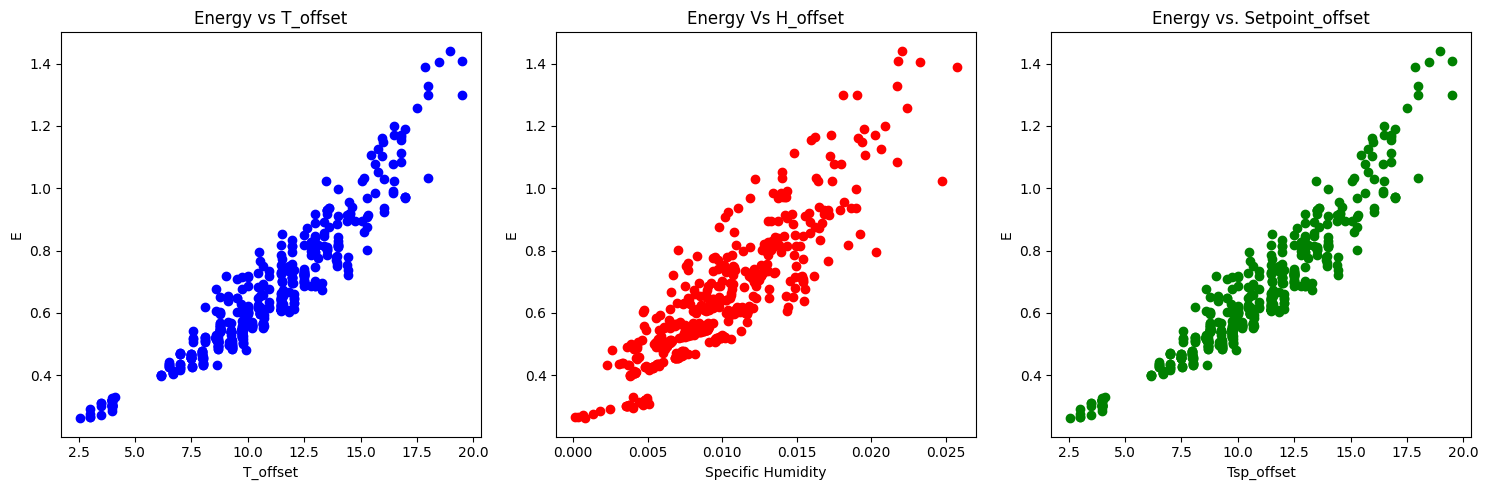

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# First subplot
axes[0].scatter(df['tsp_offset'][::60], df['energy'][::60], color='blue')
axes[0].set_title("Energy vs T_offset")
axes[0].set_xlabel("T_offset")
axes[0].set_ylabel("E")

# Second subplot
axes[1].scatter(df['h_offset'][::60], df['energy'][::60], color='red')
axes[1].set_title("Energy Vs H_offset")
axes[1].set_xlabel("Specific Humidity")
axes[1].set_ylabel("E")

# Third subplot
axes[2].scatter(df['tsp_offset'][::60], df['energy'][::60], color='green')
axes[2].set_title("Energy vs. Setpoint_offset")
axes[2].set_xlabel("Tsp_offset")
axes[2].set_ylabel("E")


plt.tight_layout()
plt.show()


In [8]:
# Relationshp of Energy with past timestep
lagged_df = pd.DataFrame()
lagged_df['T0'] = df['energy']
lookback_windows = [10, 20, 30, 40, 50, 60]

# Create lagged columns
for lag in lookback_windows:
    lagged_df[f'T-{lag}'] = df['energy'].shift(lag)

lagged_df.corr()

,T0,T-10,T-20,T-30,T-40,T-50,T-60
T0,1.000000,0.971244,0.948133,0.924512,0.902493,0.879803,0.855755
T-10,0.971244,1.000000,0.971202,0.948058,0.924430,0.902396,0.879677
T-20,0.948133,0.971202,1.000000,0.971161,0.948000,0.924351,0.902290
T-30,0.924512,0.948058,0.971161,1.000000,0.971131,0.947949,0.924272
T-40,0.902493,0.924430,0.948000,0.971131,1.000000,0.971100,0.947894
T-50,0.879803,0.902396,0.924351,0.947949,0.971100,1.000000,0.971070
T-60,0.855755,0.879677,0.902290,0.924272,0.947894,0.971070,1.000000


In [9]:
df.describe()

,timestamp,t_room,rh_room,t_out,rh_out,setpoint,h_room,h_out,t_offset,tsp_offset,h_offset,energy
count,30495,30495.000000,30495.000000,30495.000000,30495.000000,30495.000000,30495.000000,30495.000000,30495.000000,30495.000000,30495.000000,30495.000000
mean,2024-06-11 14:07:00,24.250765,73.790818,32.817978,75.467060,22.347500,0.014079,0.023970,8.567214,10.470479,0.009891,0.640402
min,2024-06-01 00:00:00,22.000000,39.000000,25.570000,42.000000,22.000000,0.006446,0.015418,0.982118,2.570000,0.000149,0.260309
25%,2024-06-06 07:03:30,24.132747,72.000000,30.580000,70.000000,22.000000,0.013720,0.021979,6.351082,8.580000,0.007019,0.508626
50%,2024-06-11 14:07:00,24.433858,77.000000,32.520000,74.000000,22.500000,0.014965,0.023287,8.088918,10.020000,0.009207,0.604093
75%,2024-06-16 21:10:30,24.621184,79.000000,34.470000,83.000000,22.500000,0.015257,0.025989,10.711688,12.470000,0.012591,0.737217
max,2024-06-22 04:14:00,25.000000,85.000000,43.470000,94.000000,23.000000,0.016297,0.040522,21.031952,21.340000,0.031275,1.771465
std,NaN,0.577246,8.441032,3.154031,8.991912,0.366322,0.001915,0.003421,3.425912,3.163035,0.004350,0.209980


### ML Setup

In [7]:
# selecting features to predict energy
features = ['h_offset', 't_offset', 'tsp_offset', 'energy']

X = df[features].astype('float')
y = df['energy'].astype('float')

X = X.values
y = y.values

# Constants
sequence_length = 10 # looking 10 timesteps into the past
delay = 10 # Predicting 10 timesteps into the future

In [8]:
# Normalizing Data using Minmax scalar
test_split = 0.7

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_X.fit(X[:int(len(X)*test_split)])
scaler_y.fit(y.reshape(-1, 1)[:int(len(y)*test_split)])

X = scaler_X.transform(X)
y = scaler_y.transform(y.reshape(-1, 1))

# # Saving the scalar
with open('checkpoints/scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)

with open('checkpoints/scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

In [9]:
def prepare_data(X_data, y_data, lookback, delay, step=1, target_column=0):
    """
    Prepares input-output pairs for a sequential model.

    Parameters:
        data (numpy array): The dataset, typically a 2D array (samples x features).
        lookback (int): Number of timesteps to look back for each input sequence.
        delay (int): Number of timesteps into the future for the output value.
        step (int): The step size for sampling (default is 1).
        target_column (int): Index of the column in the data to use as the target (default is 0).

    Returns:
        Tuple of numpy arrays: (inputs, targets)
        - inputs: 3D array of shape (num_sequences, lookback, num_features)
        - targets: 1D array of shape (num_sequences,)
    """
    inputs = []
    targets = []

    for i in range(lookback, len(X_data) - delay):
        # Select the input sequence
        sequence = X_data[i - lookback:i:step]
        inputs.append(sequence)
        
        # Select the target value
        target = y_data[i + delay]
        targets.append(target)

    return np.array(inputs), np.array(targets)

X_seq, y_seq = prepare_data(X, y, sequence_length, delay)

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=(1-test_split), shuffle=False)

In [10]:
# Model Definition
model_name = "bigru"
input_shape = (sequence_length, X.shape[1])

model_map = {
    "cnn": build_cnn_model,
    "lstm": build_lstm_model,
    "gru": build_gru_model,
    "bilstm": build_bilstm_model,
    "bigru": build_bigru_model,
    "cnn_lstm": build_cnn_lstm_model,
    "cnn_gru": build_cnn_gru_model,
    "lstm_attention": build_lstm_attention_model,
    "gru_attention": build_gru_attention_model
}

model = model_map[model_name](input_shape) 

# Loading model
# checkpoint_path = "checkpoints/"+ model_name + str(delay) + ".h5"
# model = tf.keras.models.load_model(checkpoint_path)

In [22]:
# Train the model
early_stopping = EarlyStopping(
    monitor='val_mae',   # Metric to monitor
    patience=10,           # Number of epochs with no improvement to wait
    mode='min',           # 'min' because we want val_loss to decrease
    restore_best_weights=True  # Restore the best weights
)

history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_split=0.2, 
                    shuffle=True, 
                    callbacks=[early_stopping]
                    )
# Save the model
checkpoint_path = "checkpoints/"+ model_name + str(delay) + ".h5"
model.save(checkpoint_path)


Epoch 1/50
534/534 [==============================] - 5s 7ms/step - loss: 0.0017 - mae: 0.0231 - val_loss: 0.0019 - val_mae: 0.0196
Epoch 2/50
534/534 [==============================] - 3s 6ms/step - loss: 0.0014 - mae: 0.0191 - val_loss: 0.0023 - val_mae: 0.0278
Epoch 3/50
534/534 [==============================] - 4s 7ms/step - loss: 0.0014 - mae: 0.0187 - val_loss: 0.0018 - val_mae: 0.0176
Epoch 4/50
534/534 [==============================] - 3s 6ms/step - loss: 0.0013 - mae: 0.0180 - val_loss: 0.0018 - val_mae: 0.0175
Epoch 5/50
534/534 [==============================] - 3s 6ms/step - loss: 0.0013 - mae: 0.0182 - val_loss: 0.0018 - val_mae: 0.0178
Epoch 6/50
534/534 [==============================] - 3s 6ms/step - loss: 0.0013 - mae: 0.0178 - val_loss: 0.0018 - val_mae: 0.0172
Epoch 7/50
534/534 [==============================] - 3s 6ms/step - loss: 0.0013 - mae: 0.0173 - val_loss: 0.0018 - val_mae: 0.0229
Epoch 8/50
534/534 [==============================] - 4s 7ms/step - loss: 0.

### Model Evaluation

953/953 [==============================] - 3s 3ms/step


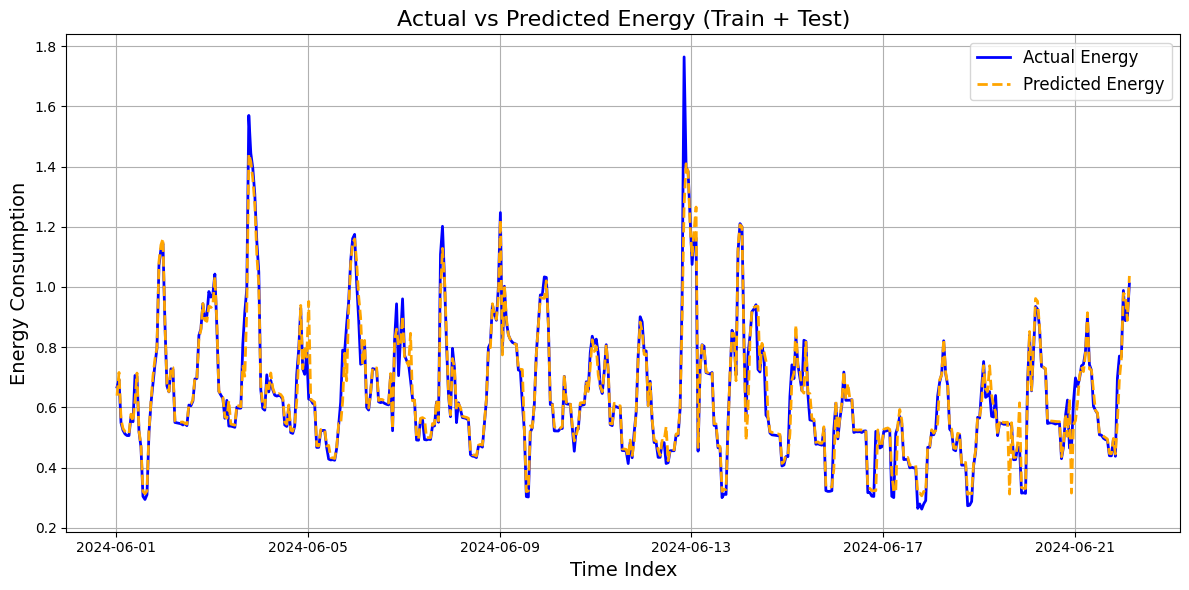

In [26]:
# Predict on both train and test data
predicted = model.predict(X_seq)
predicted = scaler_y.inverse_transform(predicted)
df['predicted_energy'] = np.concatenate([np.full(sequence_length + delay, np.nan), predicted.squeeze()])


output_file_path = "output/"+ model_name + "_10m.csv"
df.to_csv(output_file_path)

# Display hourly energy
indices = np.arange(20, df.shape[0], 60)

# Plot the combined actual and predicted energy values
plt.figure(figsize=(12, 6))
plt.plot(df.loc[indices, 'timestamp'], df.loc[indices, 'energy'], label='Actual Energy', color='blue', linewidth=2)
plt.plot(df.loc[indices, 'timestamp'], df.loc[indices, 'predicted_energy'], label='Predicted Energy', color='orange', linestyle='--', linewidth=2)

plt.title('Actual vs Predicted Energy (Train + Test)', fontsize=16)
plt.xlabel('Time Index', fontsize=14)  # Replace with actual time unit if available
plt.ylabel('Energy Consumption', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# prediction on test dataset
predicted = model.predict(X_test)
predicted = scaler_y.inverse_transform(predicted)
actual = scaler_y.inverse_transform(y_test)
# np.concatenate([np.full(sequence_length + delay, np.nan), predicted.squeeze()])

# Calculate MSE
mse = np.mean((predicted - actual) ** 2)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = np.mean(np.abs(predicted - actual))

# Calculate MAPE
mape = np.mean(np.abs((actual - predicted) / actual)) * 100


# Print the results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")

286/286 [==============================] - 1s 3ms/step
MSE: 0.0016
RMSE: 0.0396
MAE: 0.0177
MAPE: 3.6734%


### Running Simulation on Whole Training Set (Optional)

In [12]:
# Predicting on a single datapoint

def predict_energy(X_, y_):
    # Normalizing
    X_ = scaler_X.transform(X_)
    y_ = scaler_y.transform(y_)

    # Predicting
    X_ = np.expand_dims(X_, 0)
    # E_pred = model.predict(X_)
    E_pred = model(X_).numpy()
    
    # Inverse Normalization
    E_pred = scaler_y.inverse_transform(E_pred).squeeze()
    E_real = scaler_y.inverse_transform(y_).squeeze()

    return E_pred, E_real

In [13]:
## Simulation Constant

v = 0.5  # average air speed, [m/s]
activity = "Typing"  # participant's activity description
met = met_typical_tasks[activity]  # activity met, [met]
vr = v_relative(v=v, met=met) # calculate the relative air velocity

# calculate total clothing insulation
garments = ["Sweatpants", "T-shirt", "Shoes or sandals"]
icl = sum(
    [clo_individual_garments[item] for item in garments]
)
icl = 0.7
clo = clo_dynamic(clo=icl, met=met)

min_pmv = -0.1
max_pmv = 0.1
setpoint_offset = 0.1
system_interval = 10 # runs at every 10 minutes
runtime = df.shape[0] # minutes (full day)

In [14]:
# sensor input
room_temperature_database = df[:sequence_length+1]['t_room'].values
room_humidity_database = df['rh_room'].values
outdoor_temperature_database = df['t_out'].values
outdoor_humidity_database = df['rh_out'].values
setpoint_database = df[:sequence_length+1]['setpoint'].values

for t in range(sequence_length, runtime, system_interval):
    # sensor input
    room_temperature = room_temperature_database[t]
    room_humidity = room_humidity_database[t]
    outdoor_temperature = outdoor_temperature_database[t]
    outdoor_humidity = outdoor_humidity_database[t]

    tr = room_temperature + 2
    results = pmv_ppd(tdb=room_temperature, tr=tr, vr=vr, rh=room_humidity, met=met, clo=clo, standard="ASHRAE", limit_inputs=False )
    pmv = results['pmv']
    
    # if room temperature is within comfort zone, Select setpoint that achieves maximum acceptable pmv score
    setpoint = room_temperature
    if min_pmv <= pmv <= max_pmv:
        while min_pmv <= pmv <= max_pmv:
            setpoint = setpoint + setpoint_offset
            tr = setpoint + 2
            results = pmv_ppd(tdb=setpoint, tr=tr, vr=vr, rh=room_humidity, met=met, clo=clo, standard="ASHRAE", limit_inputs=False)
            pmv = results['pmv']
        
        setpoint = setpoint-setpoint_offset
    
    # if room temperature is outside of comfort zone
    else:
        # if pmv is positive, reduce temperature for comfort
        if pmv > 0:
            while pmv >= max_pmv:
                setpoint = setpoint -setpoint_offset
                tr = setpoint + 2
                results = pmv_ppd(tdb=setpoint, tr=tr, vr=vr, rh=room_humidity, met=met, clo=clo, standard="ASHRAE", limit_inputs= False)
                pmv = results['pmv']
        
        # if pmv is negative, increase temperature for comfort
        else:
            while pmv <= min_pmv:
                setpoint = setpoint + setpoint_offset
                tr = setpoint + 2
                results = pmv_ppd(tdb=setpoint, tr=tr, vr=vr, rh=room_humidity, met=met, clo=clo, standard="ASHRAE", limit_inputs= False)
                pmv = results['pmv']

    setpoint = np.round(setpoint)    
    # Simulate room temperature and add them to room temperature database which can be used for next inputs
    T_i = room_temperature
    for i in range(system_interval):
        
        # if there is no datapoint left in the database i.e at the last minute, stop the loop
        if t+i == runtime:
            break

        T_o = outdoor_temperature_database[t+i]
        rh_i = room_humidity_database[t+i]
        rh_o = outdoor_humidity_database[t+i]

        if (T_i - setpoint) > 2:
            heat_gain = ac.calculate_total_heat_gain(T_indoor=T_i, T_outdoor=T_o, RH_indoor=rh_i, RH_outdoor=rh_o)
            T_i = ac.calculate_room_temperature_after_cooling(heat_gain, T_i, 60)
        elif setpoint > T_i:
            heat_gain = ac.calculate_total_heat_gain(T_indoor=T_i, T_outdoor=T_o, RH_indoor=rh_i, RH_outdoor=rh_o)
            T_i = ac.calculate_room_temperature_when_standby(heat_gain, T_i, 60)
        else:
            pass

        room_temperature_database = np.append(room_temperature_database, T_i)
        setpoint_database = np.append(setpoint_database, setpoint)
        print('timestep : ',t+i, ' PMV : ',pmv, 'Setpoint : ',setpoint, 'Room Temp : ', T_i)
   
room_temperature_database = room_temperature_database[:-1]
setpoint_database = setpoint_database[:-1]

timestep :  10  PMV :  -0.08 Setpoint :  25.0 Room Temp :  24.861348078967175
timestep :  11  PMV :  -0.08 Setpoint :  25.0 Room Temp :  25.45836225663114
timestep :  12  PMV :  -0.08 Setpoint :  25.0 Room Temp :  25.45836225663114
timestep :  13  PMV :  -0.08 Setpoint :  25.0 Room Temp :  25.45836225663114
timestep :  14  PMV :  -0.08 Setpoint :  25.0 Room Temp :  25.45836225663114
timestep :  15  PMV :  -0.08 Setpoint :  25.0 Room Temp :  25.45836225663114
timestep :  16  PMV :  -0.08 Setpoint :  25.0 Room Temp :  25.45836225663114
timestep :  17  PMV :  -0.08 Setpoint :  25.0 Room Temp :  25.45836225663114
timestep :  18  PMV :  -0.08 Setpoint :  25.0 Room Temp :  25.45836225663114
timestep :  19  PMV :  -0.08 Setpoint :  25.0 Room Temp :  25.45836225663114
timestep :  20  PMV :  0.14 Setpoint :  26.0 Room Temp :  26.048590702528948
timestep :  21  PMV :  0.14 Setpoint :  26.0 Room Temp :  26.048590702528948
timestep :  22  PMV :  0.14 Setpoint :  26.0 Room Temp :  26.04859070252894

In [15]:
system_running_records = pd.DataFrame()
system_running_records['t_room'] = room_temperature_database
system_running_records['t_out'] = outdoor_temperature_database
system_running_records['rh_room'] = room_humidity_database
system_running_records['rh_out'] = outdoor_humidity_database
system_running_records['setpoint'] = setpoint_database
system_running_records['t_offset'] = system_running_records['t_out']-system_running_records['t_room']
system_running_records['tsp_offset'] = system_running_records['t_out']-system_running_records['setpoint']

H_indoor = []
H_outdoor = []
for i in range(system_running_records.shape[0]):
    RH_indoor = system_running_records.loc[i, "rh_room"]
    RH_outdoor = system_running_records.loc[i, "rh_out"]
    T_indoor = system_running_records.loc[i, "t_room"]
    T_outdoor = system_running_records.loc[i, "t_out"]
    w1 = calculate_specific_humidity(T_indoor, RH_indoor)
    w2 = calculate_specific_humidity(T_outdoor, RH_outdoor)
    H_indoor.append(w1)
    H_outdoor.append(w2)

system_running_records["h_room"] = H_indoor
system_running_records["h_out"] = H_outdoor
system_running_records['h_offset'] = system_running_records['h_out'] - system_running_records['h_room']


In [16]:
# We can either set the initial energy to 0 
# system_running_records['energy'] = 0.0

# Or calculate the initial energy through AC model
for i in range(sequence_length+delay+1):
    T_indoor= system_running_records.loc[i,'t_room']
    T_outdoor = system_running_records.loc[i, 't_out']
    RH_indoor = system_running_records.loc[i, 'rh_room']
    RH_outdoor = system_running_records.loc[i, 'rh_out']
    T_setpoint = system_running_records.loc[i,'setpoint']
    energy= ac.calculate_energy_consumption(T_indoor, T_outdoor, RH_indoor, RH_outdoor, T_setpoint)
    system_running_records.loc[i, 'energy'] = energy


for t in range(sequence_length, len(system_running_records)-delay):
    
    # Taking past 'sequence length' timesteps as input to predict current energy
    X_ = system_running_records.loc[t-sequence_length:t-1, features].values
    y_ = system_running_records.loc[t+delay]['energy'].reshape(-1, 1)
    
    # Predicting predicted and real current value in Amps
    E_pred, _ = predict_energy(X_, y_)
    
    # Store the new prediction to the dataframe and repeat
    system_running_records.loc[t+delay, 'energy'] = E_pred


system_running_records['saved_energy'] = df['energy'] - system_running_records['energy']

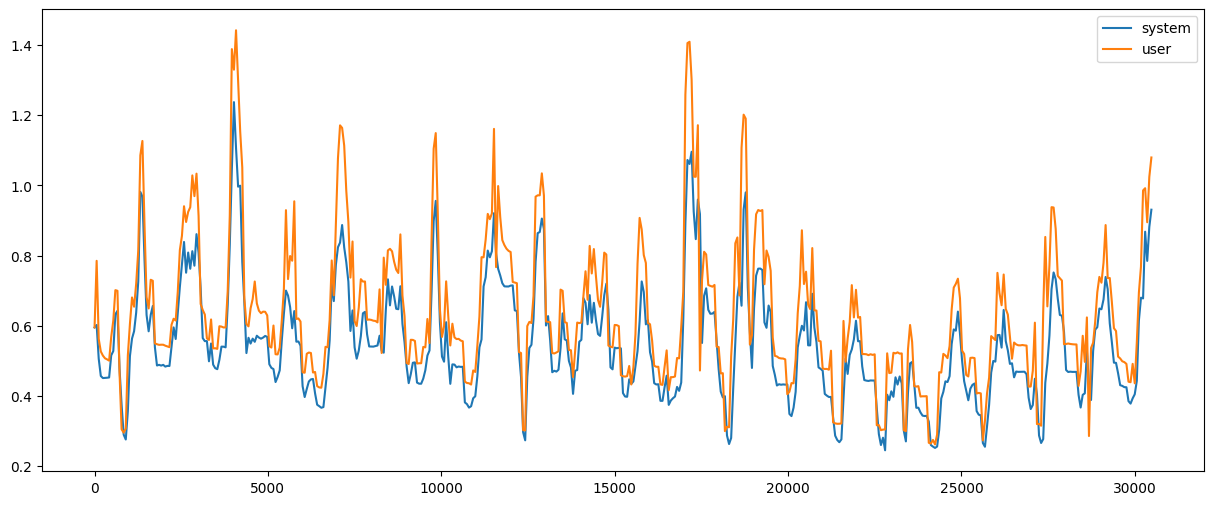

In [17]:
plt.figure(figsize = [15, 6])
system_running_records['energy'][::60].plot(label='system')
df['energy'][::60].plot(label='user')
plt.legend()

{'whiskers': [<matplotlib.lines.Line2D at 0x18f1ce50df0>,
 'caps': [<matplotlib.lines.Line2D at 0x18f1cf84370>,
 'boxes': [<matplotlib.lines.Line2D at 0x18f1ce50b50>],
 'medians': [<matplotlib.lines.Line2D at 0x18f1cf848b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x18f1cf84b50>],
 'means': []}

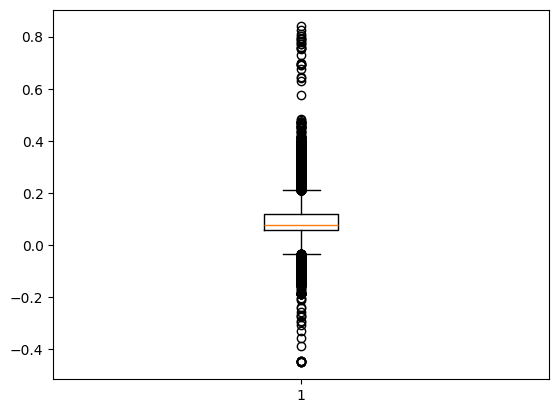

In [19]:
# system_running_records['saved_energy'].plot()
plt.boxplot(system_running_records['saved_energy'])